# Implementation of Wasserstein GANs
Reference: https://arxiv.org/pdf/1701.07875.pdf

In [22]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

In [3]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image

In [5]:
import numpy as np
import datetime
import scipy.misc

In [6]:
MODEL_NAME = 'W-GAN'
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
def to_cuda(x):
    return x.to(DEVICE)

In [21]:
def get_sample_image(G, n_noise=100):
    """
        save sample 100 images
    """
    for num in range(10):
        for i in range(10):
            z = to_cuda(torch.randn(1, n_noise))
            y_hat = G(z)
            line_img = torch.cat((line_img, y_hat.view(28, 28)), dim=1) if i > 0 else y_hat.view(28, 28)
        all_img = torch.cat((all_img, line_img), dim=0) if num > 0 else line_img
    img = all_img.cpu().data.numpy()
    return img

In [8]:
def n_critic(step, nc=5):
    if step < 25 or step % 500 == 0:
        return 100
    return nc

In [10]:
class Discriminator(nn.Module):
    """
        Convolutional Discriminator for MNIST
    """
    def __init__(self, in_channel=1, num_classes=1):
        super(Discriminator, self).__init__()
        self.layer1 = nn.Sequential(# 28 -> 14
            nn.Conv2d(in_channel, 128, 3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
        )
        self.layer2 = nn.Sequential(# 14 -> 7
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
        )
        self.layer3 = nn.Sequential(# 7 -> 4
            nn.Conv2d(256, 512, 3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.AvgPool2d(4),
        )
        self.layer4 = nn.Sequential(# reshape input, 512 -> 1
            nn.Linear(512, 1),
        )
    
    def forward(self, x, y=None):
        y_ = self.layer1(x)
        y_ = self.layer2(y_)
        y_ = self.layer3(y_)
        y_ = y_.view(y_.size(0), -1)
        y_ = self.layer4(y_)
        return y_

In [11]:
class Generator(nn.Module):
    """
        Convolutional Generator for MNIST
    """
    def __init__(self, input_size=100, label_size=10, num_classes=784):
        super(Generator, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(input_size, 4*4*512),
            nn.ReLU(),
        )
        self.layer2 = nn.Sequential(# input: 4 by 4, output: 7 by 7
            nn.ConvTranspose2d(512, 256, 3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.layer3 = nn.Sequential(# input: 7 by 7, output: 14 by 14
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.layer4 = nn.Sequential(# input: 14 by 14, output: 28 by 28
            nn.ConvTranspose2d(128, 1, 4, stride=2, padding=1),
            nn.Tanh(),
        )
        
    def forward(self, x, y=None):
        x = x.view(x.size(0), -1)
        y_ = self.layer1(x)
        y_ = y_.view(y_.size(0), 512, 4, 4)
        y_ = self.layer2(y_)
        y_ = self.layer3(y_)
        y_ = self.layer4(y_)
        return y_

In [12]:
D = to_cuda(Discriminator())
G = to_cuda(Generator())

In [13]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5, 0.5, 0.5),
                                std=(0.5, 0.5, 0.5))]
)

In [14]:
mnist = datasets.MNIST(root='../data/', train=True, transform=transform, download=True)

In [15]:
batch_size = 64

In [16]:
data_loader = DataLoader(dataset=mnist, batch_size=batch_size, shuffle=True, drop_last=True)

In [17]:
D_opt = torch.optim.RMSprop(D.parameters(), lr=0.00005)
G_opt = torch.optim.RMSprop(G.parameters(), lr=0.00005)

In [18]:
max_epoch = 100 # need more than 100 epochs for training generator
step = 0
g_step = 0
n_noise = 100

In [19]:
D_labels = to_cuda(torch.ones(batch_size)) # Discriminator Label to real
D_fakes = to_cuda(torch.zeros(batch_size)) # Discriminator Label to fake

In [20]:
for epoch in range(max_epoch):
    for idx, (images, labels) in enumerate(data_loader):
        step += 1
                   
        # Training Discriminator
        x = to_cuda(images)
        x_outputs = D(x)

        z = to_cuda(torch.randn(batch_size, n_noise))
        z_outputs = D(G(z))
        D_x_loss = torch.mean(x_outputs)
        D_z_loss = torch.mean(z_outputs)
        D_loss = (D_x_loss - D_z_loss) * -1
        
        D.zero_grad()
        D_loss.backward()
        D_opt.step()
        # Parameter(Weight) Clipping for K-Lipshitz constraint
        for p in D.parameters():
            p.data.clamp_(-0.01, 0.01)
                    
        if step % n_critic(g_step) == 0:
            g_step += 1
            # Training Generator
            z = to_cuda(torch.randn(batch_size, n_noise))
            z_outputs = D(G(z))
            G_loss = -torch.mean(z_outputs, 0)

            D.zero_grad()
            G.zero_grad()
            G_loss.backward()
            G_opt.step()
        
        if step % 1000 == 0:
            print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, max_epoch, step, -D_loss.data[0], -G_loss.data[0]))

/home/yangyangii/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 1/100, Step: 1000, D Loss: 0.017095103859901428, G Loss: 0.0012036400148645043
Epoch: 2/100, Step: 2000, D Loss: 0.017718082293868065, G Loss: 0.0010331009980291128
Epoch: 3/100, Step: 3000, D Loss: 0.01676984131336212, G Loss: 0.0014365429524332285
Epoch: 4/100, Step: 4000, D Loss: 0.017174312844872475, G Loss: 0.0011718133464455605
Epoch: 5/100, Step: 5000, D Loss: 0.0161919966340065, G Loss: 0.001780262216925621
Epoch: 6/100, Step: 6000, D Loss: 0.015564285218715668, G Loss: 0.0021006797906011343
Epoch: 7/100, Step: 7000, D Loss: 0.01441947277635336, G Loss: 0.0016755735268816352
Epoch: 8/100, Step: 8000, D Loss: 0.013035103678703308, G Loss: 0.004355377517640591
Epoch: 9/100, Step: 9000, D Loss: 0.011423908174037933, G Loss: 0.005288329441100359
Epoch: 10/100, Step: 10000, D Loss: 0.009811108000576496, G Loss: 0.00740552693605423
Epoch: 11/100, Step: 11000, D Loss: 0.0062982444651424885, G Loss: 0.00891021080315113
Epoch: 12/100, Step: 12000, D Loss: 0.006212606094777584, G 

## Sample

In [17]:
import scipy.misc

/home/yangyangii/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  This is separate from the ipykernel package so we can avoid doing imports until


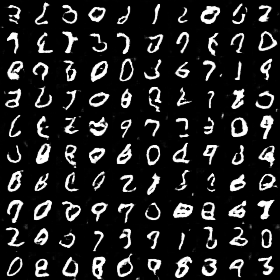

In [27]:
# generation to image
G.eval()
scipy.misc.toimage(get_sample_image(G))

In [34]:
# generation to image
z = to_cuda(torch.randn(1, n_noise))
fakeimg = G(z).view(28, 28)
img = fakeimg.cpu().data.numpy()
scipy.misc.toimage(img)

/home/yangyangii/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  """


In [15]:
def save_checkpoint(state, file_name='checkpoint.pth.tar'):
    torch.save(state, file_name)

In [16]:
# Saving params.
# torch.save(D.state_dict(), 'D_c.pkl')
# torch.save(G.state_dict(), 'G_c.pkl')
save_checkpoint({'epoch': epoch + 1, 'state_dict':D.state_dict(), 'optimizer' : D_opt.state_dict()}, 'D_w.pth.tar')
save_checkpoint({'epoch': epoch + 1, 'state_dict':G.state_dict(), 'optimizer' : G_opt.state_dict()}, 'G_w.pth.tar')